In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import time
from sqlalchemy import create_engine
import pyodbc
import db_config

listing_data = []

###Extracting DATA 
def extract_data():
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
        "Accept-Language": "en-US,en;q=0.9",
    }
    for page in range(1, 11):
        url = f"https://www.pakwheels.com/used-cars/search/-/featured_1/?page={page}"
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, "html.parser")
        all_listings = soup.find_all("li", class_="classified-listing")
        
        #print(f'Extracted data from page no: {page}')
        
        if not all_listings:
            continue
        cleaning_data(all_listings, page)

###Cleaning DATA FROM SOUP
def cleaning_data(all_listings, page):
    for car in all_listings:
        car_title = car.find('h3').get_text(strip=True)
        car_price = car.find("div", class_="price-details").get_text(strip=True)
        car_city = car.select_one(".list-unstyled.search-vehicle-info li").get_text(strip=True) 
        car_model_year = car.select_one(".list-unstyled.search-vehicle-info-2 li").get_text(strip=True)
        car_milage = car.select_one(".list-unstyled.search-vehicle-info-2 li:nth-of-type(2)").get_text(strip=True)
        car_fuel_type = car.select_one(".list-unstyled.search-vehicle-info-2 li:nth-of-type(3)").get_text(strip=True)
        car_power = car.select_one(".list-unstyled.search-vehicle-info-2 li:nth-of-type(4)").get_text(strip=True)
        car_transmission_type = car.select_one(".list-unstyled.search-vehicle-info-2 li:nth-of-type(5)").get_text(strip=True)
    
        listing_data.append({
            "Title": car_title,
            "Price": car_price,
            "City": car_city,
            "Model Year": car_model_year,
            "Mileage": car_milage,
            "Fuel Type": car_fuel_type,
            "Power In CC": car_power,
            "Transmission Type": car_transmission_type
        })
    #print(f'Cleaned data from page no: {page}')

###LOAD DATA TO CSV
def load_to_csv(listing_data):
    file_name = "pakwheels_listings.csv"
    df = pd.DataFrame(listing_data)
    if os.path.exists(file_name):
        # If CSV exists, append new data without writing headers
        df.to_csv(file_name, mode='a', index=False, header=False)
    else:
        # If CSV does not exist, create it and write headers
        df.to_csv(file_name, mode='w', index=False, header=True)

###LOAD DATA TO DATABASE 
def load_to_database():

    # --- Configuration ---
    server = db_config.DB_SERVER       # SQL Server name or IP
    database = db_config.DB_NAME   # target database
    username = db_config.DB_USER
    password = db_config.DB_PASSWORD
    table_name = db_config.DB_TABLE_NAME
    csv_file = "pakwheels_listings.csv"
    

    # --- Step 1: Connect to master DB to check/create database ---
    conn_str_master = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE=master;UID={username};PWD={password}"
    conn = pyodbc.connect(conn_str_master, autocommit=True)
    cursor = conn.cursor()

    # Check if database exists
    cursor.execute(f"SELECT database_id FROM sys.databases WHERE Name = '{database}'")
    db_exists = cursor.fetchone()

    if not db_exists:
        cursor.execute(f"CREATE DATABASE {database}")
        print(f"Database '{database}' created.")
    else:
        print(f"Database '{database}' already exists.")

    cursor.close()
    conn.close()

    # --- Step 2: Load CSV into pandas DataFrame ---
    df = pd.read_csv(csv_file)

    # --- Step 3: Connect to the target database using SQLAlchemy ---
    engine = create_engine(f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server")

    # --- Step 4: Dump data to table ---
    # 'if_exists=append' will add new rows if table exists, otherwise it creates a new table
    df.to_sql(table_name, con=engine, if_exists='append', index=False)
    print("CSV data loaded into SQL Server successfully!")
    
    
extract_data()
load_to_csv(listing_data)
load_to_database()

Database 'PakwheelsDB' already exists.
CSV data loaded into SQL Server successfully!


# Analysis

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
analysis_df = pd.DataFrame(listing_data)

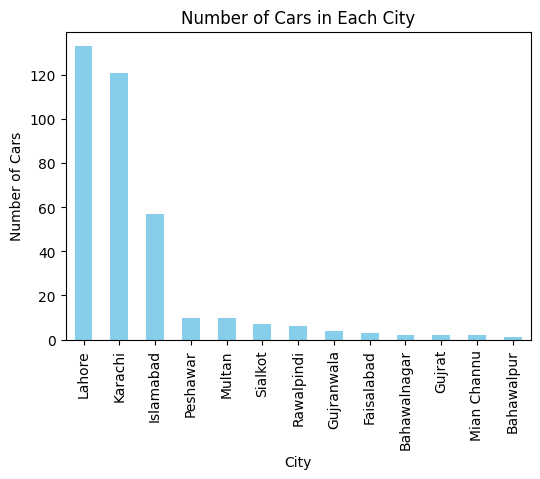

In [ ]:

#Analysis 1: Number of listed cars in each cities
city_counts = analysis_df['City'].value_counts()
plt.figure(figsize=(6, 4))
city_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Cars in Each City')
plt.xlabel('City')
plt.ylabel('Number of Cars')
#plt.xticks(rotation=45)
plt.show()

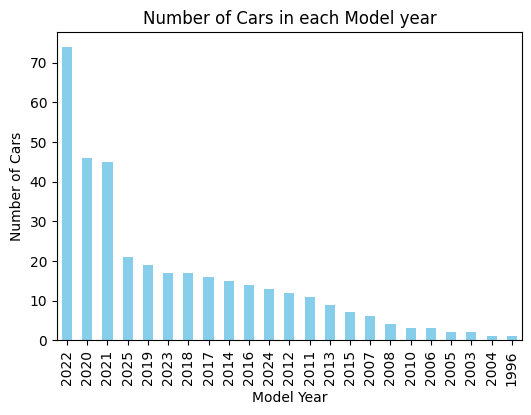

In [14]:
#Analysis 2: Number of listed availbile per modal year
model_counts = analysis_df['Model Year'].value_counts()
plt.figure(figsize=(6, 4))
model_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Cars in each Model year')
plt.xlabel('Model Year')
plt.ylabel('Number of Cars')
#plt.xticks(rotation=45)
plt.show()

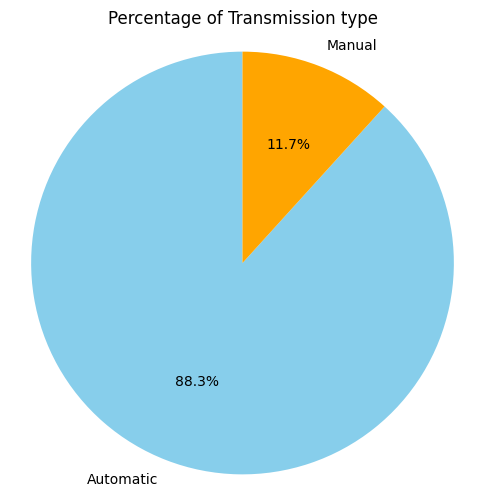

In [15]:
#Analysis 3: Percentage of cars in each transmission type
transmission_counts = analysis_df['Transmission Type'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(transmission_counts, labels=transmission_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue','orange','green'])
plt.title('Percentage of Transmission type')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()

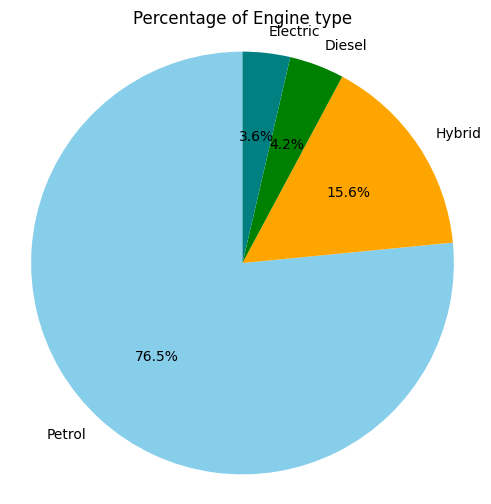

In [17]:
#Analysis 4: Number of cars availble in each engine type
fuel_counts = analysis_df['Fuel Type'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(fuel_counts, labels=fuel_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue','orange','green', 'teal'])
plt.title('Percentage of Engine type')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()